# HW2P2: Face Classification and Verification


This is the second homework in 11785: Introduction to Deep Learning consisting of two parts:
*   Face Recognition: You will be writing your own CNN model to tackle the problem of classification, consisting of 7001 identities.
*   Face Verification: You use the model trained for classification to evaluate the quality of its feature embeddings, by comparing the similarity of known and unknown identities.

For this HW, you only have to write code to implement your model architecture. Everything else has been provided for you, on the pretext that most of your time will be used up in developing the suitable model architecture for achieving satisfactory performance.

Common errors which you may face in this homeworks (because of the size of the model)


*   CUDA Out of Memory (OOM): You can tackle this problem by (1) Reducing the batch size (2) Calling `torch.cuda.empty_cache()` and `gc.collect()` (3) Finally restarting the runtime



# TODOs
As you go, please read the code and keep an eye out for TODOs.

**Structure of this notebook**:

1. **Libraries** - just run it
2. **Kaggle** - copy the code from HW1P2 and add a correct API key
3. **Configs** - specify your configs
4. **Dataset**
  - **Datasets and Dataloaders** - it's already implemented, just specify your preferred augmentations/transformations
  - **EDA and Viz** - just run it to check if your augmentations/transformations worked
5. **Model Architecture** - implement and define your preferred model architecture
6. **Loss, Optimizer, and Scheduler** - define your loss, optimizer, and a scheduler
7. **Training and Validation Functions** - includes functions for both classification and verification tasks
  - **Classification Task** - just run it
  - **Verification Task** - just run it
8. **Wandb** - add a correct API key
9. **Experiments** - make changes if needed; it will show you train/val/test accuracy for both classification and verification. **Important**: make sure you save your best model checkpoints because models in this HW take a long time to get trained
10. **Testing and Kaggle Submission** - just run it
11. **Model Finetuning** - this part might help you get a higher score on the verification part
  - **Model Implementations (CenterLoss, ArcFace, or SphereFace)** - please refer to the additional notebook and just copy the model from there
  - **Model Definition (finetuning)** - you may reuse the code from the main part
  - **Loss, Optimizer, and Scheduler Definition (finetuning)** - you may reuse the code from the main part
  - **Training Function (finetuning)** - you may reuse the code from the main part
  - **Wandb (finetuning)** - you may reuse the code from the main part
  - **Experiments (finetuning)** - you may reuse the code from the main part

Good luck!

# Libraries

In [3]:
# Run this to see what GPU you have
!nvidia-smi

Wed Feb 28 20:57:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
| 30%   53C    P8              38W / 350W |   1826MiB / 12288MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#NOTE: RESTART THE RUN TIME AFTER RUNNING THE THE CELL BELOW

In [ ]:
# Install the necessary packages. Very important: Please restart your session in Colab/Local Machine
# You can restart your session in colab by going to Runtime and then clicking restart session
!pip install wandb --quiet
!pip install torch==1.12.1 torchvision==0.13.1 torchaudio==0.12.1

In [3]:
# Import the important packages for this Homework. Feel free to add anything here you need.
import torch
from torchsummary import summary
import torchvision # This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
import torch.nn.functional as F
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Device:  cuda


In [ ]:
from google.colab import drive # Link to your drive if you are not using Colab with GCP
drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it here

# Kaggle

In [8]:
# TODO: Use the same Kaggle code from HW1P2
# !pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
# !mkdir /root/.kaggle
local_path = r'C:\Users\sx119\.kaggle\kaggle.json'
with open(local_path, "w+") as f:
    f.write('{"username":"xiaocmumsppm", "key":"a6945a839577943fd50ec98ed44d4d32"}')
    # Put your kaggle username & key here

# !chmod 600 'C:\Users\sx119\.kaggle\kaggle.json'
!icacls "C:\Users\sx119\.kaggle\kaggle.json" /grant sx119:R /inheritance:r # windows environment


processed file: C:\Users\sx119\.kaggle\kaggle.json
Successfully processed 1 files; Failed processing 0 files


In [ ]:
# Reminder: Make sure you have connected your kaggle API before running this block
!mkdir '/content/data'

!kaggle competitions download -c 11785-hw2p2-face-recognition
!unzip -qo '11785-hw2p2-face-recognition.zip' -d '/content/data'

!kaggle competitions download -c 11785-hw2p2-face-verification
!unzip -qo '11785-hw2p2-face-verification.zip' -d '/content/data'

mkdir: cannot create directory ‘/content/data’: File exists
 99% 1.70G/1.71G [00:09<00:00, 202MB/s]
100% 1.71G/1.71G [00:09<00:00, 189MB/s]
 77% 13.0M/16.8M [00:00<00:00, 136MB/s]
100% 16.8M/16.8M [00:00<00:00, 153MB/s]


# Configs

In [4]:
config = {
    'batch_size': 256, # Increase this if your GPU can handle it
    'lr': 0.1,
    'epochs': 60, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    # Include other parameters as needed.
}

# Dataset

## Datasets and Dataloaders

In [46]:
# --------------------------------------------------- #

# Data paths

# DATA_DIR    = '/content/data/11-785-s24-hw2p2-classification'

DATA_DIR = r"C:\Users\sx119\Desktop\11785data\data\11-785-s24-hw2p2-classification"
TRAIN_DIR   = os.path.join(DATA_DIR, "train")
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")

# --------------------------------------------------- #

# Transformations/augmentations of the Train dataset

"""
Refer https://pytorch.org/vision/stable/transforms.html
Implementing the right train transforms/augmentation methods is key to improving performance.
Most torchvision transforms are done on PIL images. So you convert it into a tensor at the end with ToTensor()
But there are some transforms which are performed after ToTensor() : e.g - Normalization
#Normalization Tip - Do not blindly use normalization that is not suitable for this dataset
"""
# calculate the mean and std for normalization
def normalize_mean_std(loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data, _ in loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples
    mean /= nb_samples
    std /= nb_samples
    return mean, std

# create a dataloader for calculation
normalize_loader = torch.utils.data.DataLoader(dataset = torchvision.datasets.ImageFolder(TRAIN_DIR, torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])), num_workers = 8)

# calculate the mean and std
mean, std = normalize_mean_std(normalize_loader)



In [49]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=(224, 224), scale=(1.15, 2.15)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.RandomRotation(degrees=20),
    torchvision.transforms.ColorJitter(brightness=0.5),
    torchvision.transforms.ColorJitter(contrast=0.5),
    torchvision.transforms.ColorJitter(saturation=0.5),
    torchvision.transforms.ColorJitter(hue=0.5),

    torchvision.transforms.ToTensor(),
    #normalization
    torchvision.transforms.Normalize(mean = mean, std = std)
    ]) # TODO: Specify transformations/augmentations performed on the train dataset

# --------------------------------------------------- #

# Transformations/augmentations of the Val dataset

"""
You should NOT have data augmentation on the validation set. Why?
"""


valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = mean, std = std)
    ]) # TODO: Specify transformations performed on the val dataset

# --------------------------------------------------- #

# Initializing the train and val datasets

train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = train_transforms)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform = valid_transforms)

# --------------------------------------------------- #

# Initializing the train and val dataloaders

train_loader = torch.utils.data.DataLoader(dataset       = train_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle        = True,
                                           num_workers = 8, # Uncomment this line if you want to increase your num workers
                                           pin_memory    = True)

valid_loader = torch.utils.data.DataLoader(dataset       = valid_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle        = False,
                                           num_workers = 4 # Uncomment this line if you want to increase your num workers
                                           )

In [50]:
# --------------------------------------------------- #

# Test dataset class

"""
You can do this with ImageFolder as well, but it requires some tweaking
"""

class TestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

# --------------------------------------------------- #

# Initializing the test dataset

"""
Why are we using val_transforms for Test Data?
"""

test_dataset = TestDataset(TEST_DIR, transforms = valid_transforms)

# --------------------------------------------------- #

# Initializing the test dataloader

test_loader = torch.utils.data.DataLoader(dataset    = test_dataset,
                                          batch_size = config['batch_size'],
                                          shuffle     = False,
                                          drop_last  = False,
                                          num_workers = 4 # Uncomment this line if you want to increase your num workers
                                          )

## EDA and Viz

In [51]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  7001
No. of train images  :  140020
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  256
Train batches        :  547
Val batches          :  137


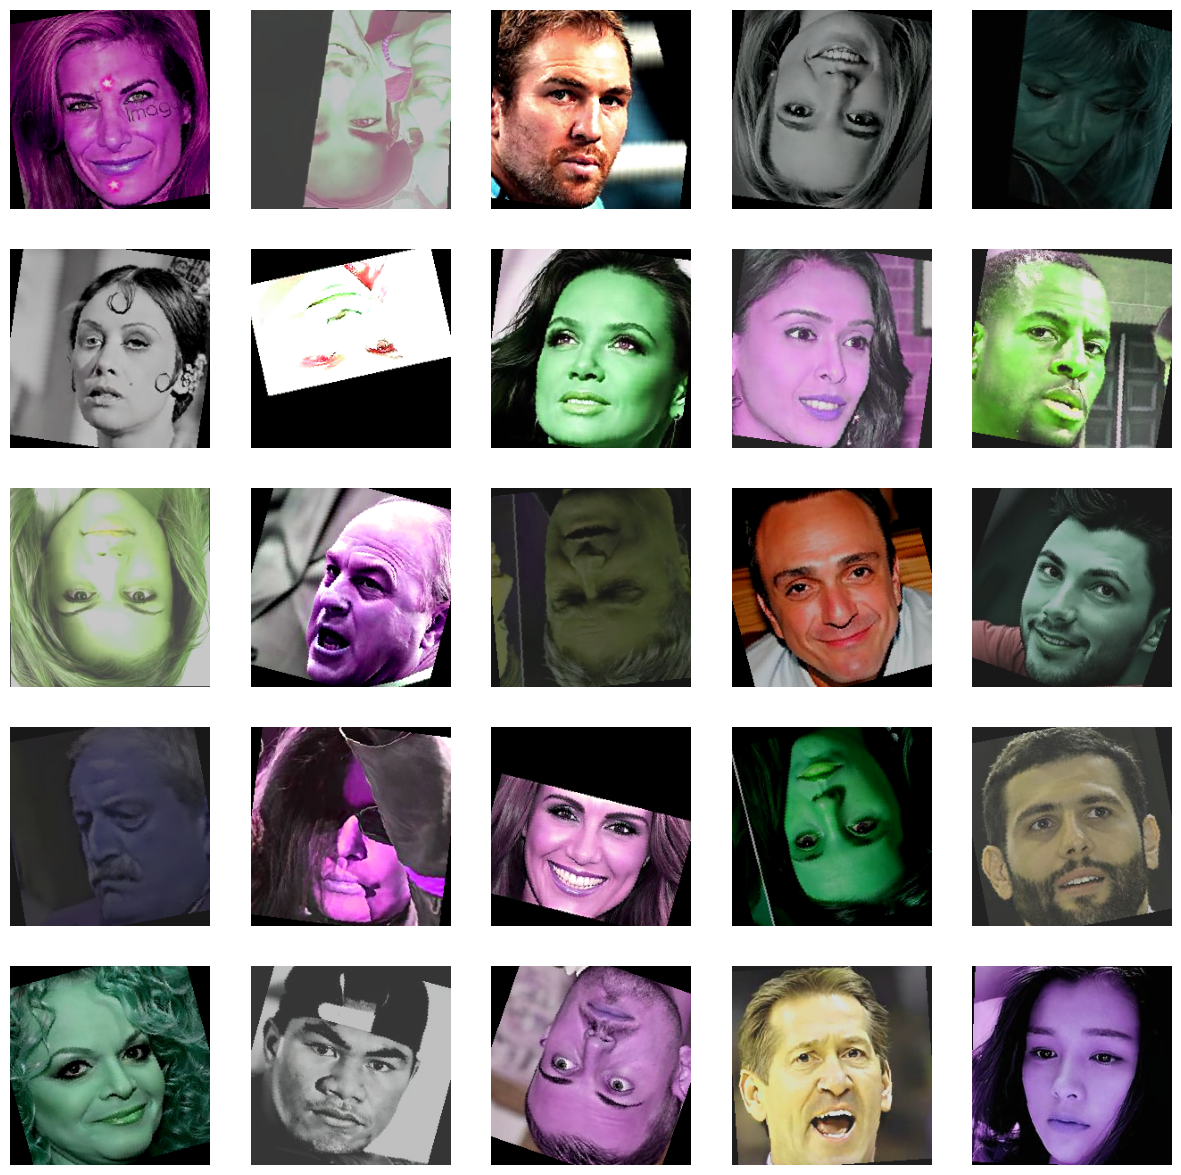

In [36]:
# Visualize a few images in the dataset

"""
You can write your own code, and you don't need to understand the code
It is highly recommended that you visualize your data augmentation as sanity check
"""

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit is 18M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next four have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 224x224. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

In [76]:
class SELayer(torch.nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(channel, channel // reduction, bias=False),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(channel // reduction, channel, bias=False),
            torch.nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ResidualBlock(torch.nn.Module):
    def __init__(self, inchannels, out_channels, stride = 1):
        super(ResidualBlock, self).__init__()
        self.bn1 = torch.nn.BatchNorm2d(inchannels)
        self.conv1 = torch.nn.Conv2d(inchannels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        
        self.relu = torch.nn.ReLU(inplace = True)
        self.swish = torch.nn.SiLU()

        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        
        self.selayer = SELayer(out_channels)

        self.shortcut = torch.nn.Sequential()

        if stride != 1 or inchannels != out_channels:
            self.shortcut = torch.nn.Sequential(torch.nn.Conv2d(inchannels, out_channels, stride = stride, kernel_size = 1, bias = False),
                                                torch.nn.BatchNorm2d(out_channels))

    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out = self.swish(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.swish(out)
        out = self.conv2(out)

        out = self.selayer(out)

        out += self.shortcut(residual)
        out = self.relu(out)

        return out


# TODO: Fill out the model definition below

class Network(torch.nn.Module):

    def __init__(self, num_classes=7001):
        super(Network, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU(inplace = True)
        self.maxpool = torch.nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.swish = torch.nn.SiLU()
        self.layer1 = self._make_layer(64, 64, 2, 1)
        self.layer2 = self._make_layer(64, 128, 2, 2)
        self.layer3 = self._make_layer(128, 256, 2, 2)
        self.layer4 = self._make_layer(256, 512, 2, 2)

        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(512, 512)
        self.batchnorm = torch.nn.BatchNorm1d(512)
        self.dropout = torch.nn.Dropout(0.5)
        self.cls_layer = torch.nn.Linear(512, num_classes)

        self._initialize_weights()
        
    def _make_layer(self, in_channels, out_channels, blocks, stride = 1):
        layer = []
        layer.append(ResidualBlock(in_channels,out_channels, stride))
        for _ in range(1, blocks):
            layer.append(ResidualBlock(out_channels, out_channels))
        return torch.nn.Sequential(*layer)


    def forward(self, x, return_feats=False):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.swish(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)

        out = self.flatten(out)
        out = self.batchnorm(out)
        out = self.linear(out)
        out = self.swish(out)
        out = self.dropout(out)
        out = self.cls_layer(out)

        return out

    #Kaiming's innitial convolution
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)

# Initialize your model
model = Network().to(DEVICE)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              SiLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              SiLU-6           [-1, 64, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
              SiLU-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
AdaptiveAvgPool2d-11             [-1, 64, 1, 1]               0
           Linear-12                    [-1, 4]             256
             ReLU-13                    [-1, 4]               0
           Linear-14                   

# Loss, Optimizer, and Scheduler Definition

In [77]:
# --------------------------------------------------- #

# Defining Loss function
# label smoothing
class LabelSmoothing(torch.nn.Module):
    def __init__(self, smoothing = 0.1):
        super(LabelSmoothing, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        log_prob = F.log_softmax(input, dim = -1)
        weight = input.new_ones(input.size()) * (self.smoothing / (input.size(-1) - 1.))
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim = -1).mean()
        return loss

criterion = LabelSmoothing()

# --------------------------------------------------- #

# Defining Optimizer
# SGD with weight decay of 0.0001 and a momentum of 0.9
optimizer = torch.optim.SGD(model.parameters(), lr = config['lr'], momentum = 0.9, weight_decay = 0.0001)

# --------------------------------------------------- #

# Defining Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=1, verbose=True)# TODO: Use a good scheduler such as ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.

# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

# Training and Validation Functions

## Classification Task

In [78]:
def train(model, dataloader, optimizer, criterion):

    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?

        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [79]:
def validate(model, dataloader, criterion):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [80]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

## Verification Task

The verification task consists of the following generalized scenario:
- You are given X unknown identitites
- You are given Y known identitites
- Your goal is to match X unknown identities to Y known identities.

We have given you a verification dataset, that consists of 960 known identities, and 1080 unknown identities. The 1080 unknown identities are split into dev (360) and test (720). Your goal is to compare the unknown identities to the 1080 known identities and assign an identity to each image from the set of unknown identities. Some unknown identities do not have correspondence in known identities, you also need to identify these and label them with a special label n000000.

Your will use/finetune your model trained for classification to compare images between known and unknown identities using a similarity metric and assign labels to the unknown identities.

This will judge your model's performance in terms of the quality of embeddings/features it generates on images/faces it has never seen during training for classification.

In [81]:
# This obtains the list of known identities from the known folder
# known_regex = "/content/data/11-785-s24-hw2p2-verification/known/*/*"
known_regex = "C:\\Users\\sx119\\Desktop\\11785data\\data\\11-785-s24-hw2p2-verification\\known\\*\\*"
# known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))]
known_paths = [i.split('\\')[-2] for i in sorted(glob.glob(known_regex))]

# Obtain a list of images from unknown folders
# unknown_dev_regex = "/content/data/11-785-s24-hw2p2-verification/unknown_dev/*"
unknown_dev_regex = "C:\\Users\\sx119\\Desktop\\11785data\\data\\11-785-s24-hw2p2-verification\\unknown_dev\\*"
# unknown_test_regex = "/content/data/11-785-s24-hw2p2-verification/unknown_test/*"
unknown_test_regex = "C:\\Users\\sx119\\Desktop\\11785data\\data\\11-785-s24-hw2p2-verification\\unknown_test\\*"

# We load the images from known and unknown folders
unknown_dev_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_dev_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]

# Why do you need only ToTensor() here?
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

unknown_dev_images = torch.stack([transforms(x) for x in unknown_dev_images])
unknown_test_images = torch.stack([transforms(x) for x in unknown_test_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done

# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6)

100%|██████████| 960/960 [00:00<00:00, 16954.60it/s]


In [82]:
def eval_verification(unknown_images, known_images, model, similarity, batch_size= config['batch_size'], mode='val'):

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size

        with torch.no_grad():
            unknown_feat = model(unknown_batch.float().to(DEVICE), return_feats=True) #Get features from model
        unknown_feats.append(unknown_feat)
        batch_bar.update()

    batch_bar.close()

    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)

    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size]
        with torch.no_grad():
              known_feat = model(known_batch.float().to(DEVICE), return_feats=True)

        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats])
    # Print the inner list comprehension in a separate cell - what is really happening?

    max_similarity_values, predictions = similarity_values.max(0) #Why are we doing an max here, where are the return values?
    max_similarity_values, predictions = max_similarity_values.cpu().numpy(), predictions.cpu().numpy()


    # Note that in unknown identities, there are identities without correspondence in known identities.
    # Therefore, these identities should be not similar to all the known identities, i.e. max similarity will be below a certain
    # threshold compared with those identities with correspondence.

    # In early submission, you can ignore identities without correspondence, simply taking identity with max similarity value
    pred_id_strings = [known_paths[i] for i in predictions] # Map argmax indices to identity strings

    # After early submission, remove the previous line and uncomment the following code

    threshold = 0.5 # You can change this threshold
    NO_CORRESPONDENCE_LABEL = 'n000000'
    pred_id_strings = []
    for idx, prediction in enumerate(predictions):
        if max_similarity_values[idx] < threshold: # why < ? Thank about what is your similarity metric
            pred_id_strings.append(NO_CORRESPONDENCE_LABEL)
        else:
            pred_id_strings.append(known_paths[prediction])

    if mode == 'val':
      true_ids = pd.read_csv('C:\\Users\\sx119\\Desktop\\11785data\\data\\11-785-s24-hw2p2-verification\\verification_dev.csv')['label'].tolist()
      # true_ids = pd.read_csv('/content/data/11-785-s24-hw2p2-verification/verification_dev.csv')['label'].tolist()
      accuracy = 100 * accuracy_score(pred_id_strings, true_ids)
      #print("Verification Accuracy = {}".format(accuracy))
      return accuracy, pred_id_strings

    elif mode == 'test':
      return pred_id_strings


In [83]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Wandb

In [ ]:
wandb.login(key="replace with your API key here") # API Key is in your wandb account, under settings (wandb.ai/settings)

In [ ]:
# Create your wandb run
run = wandb.init(
    name = "early-submission", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

# Experiments

In [84]:
best_class_acc      = 0.0
best_ver_acc        = 0.0

for epoch in range(config['epochs']):

    print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)

    print("\nEpoch {}/{}: \nTrain Acc (Classification) {:.04f}%\t Train Loss (Classification) {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config['epochs'], train_acc, train_loss, curr_lr))

    val_acc, val_loss = validate(model, valid_loader, criterion)
    print("Val Acc (Classification) {:.04f}%\t Val Loss (Classification) {:.04f}".format(val_acc, val_loss))
    scheduler.step(val_loss)
    ver_acc, pred_id_strings = eval_verification(unknown_dev_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='val')

    print("Val Acc (Verification) {:.04f}%\t ".format(ver_acc))

    # wandb.log({"train_classification_acc": train_acc,
    #            "train_classification_loss":train_loss,
    #            "val_classification_acc": val_acc,
    #            "val_classification_loss": val_loss,
    #            "val_verification_acc": ver_acc,
    #            "learning_rate": curr_lr})

    # If you are using a scheduler in your train function within your iteration loop,
    # How will you step your scheduler ?
    

    if val_acc >= best_class_acc:
        best_valid_acc = val_acc
        torch.save({'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'scheduler_state_dict':scheduler.state_dict(),
                    'val_acc': val_acc,
                    'epoch': epoch}, './checkpoint_classification.pth')
        # wandb.save('checkpoint_verification.pth')
        print("Saved best classification model")

    if ver_acc >= best_ver_acc:
      best_ver_acc = ver_acc
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': ver_acc,
                  'epoch': epoch}, './checkpoint_verification.pth')
      # wandb.save('checkpoint_verification.pth')
      print("Saved verification model")

### Finish your wandb run
# run.finish()


Epoch 1/60



Epoch 1/60: 
Train Acc (Classification) 0.0214%	 Train Loss (Classification) 8.8138	 Learning Rate 0.1000


Val Acc (Classification) 0.0428%	 Val Loss (Classification) 8.6896


Val Acc (Verification) 0.2778%	 
Saved best classification model
Saved verification model

Epoch 2/60



Epoch 2/60: 
Train Acc (Classification) 0.1400%	 Train Loss (Classification) 8.4227	 Learning Rate 0.1000


Val Acc (Classification) 0.6273%	 Val Loss (Classification) 7.9342


Val Acc (Verification) 1.1111%	 
Saved best classification model
Saved verification model

Epoch 3/60



Epoch 3/60: 
Train Acc (Classification) 1.1940%	 Train Loss (Classification) 7.5634	 Learning Rate 0.1000


Val Acc (Classification) 3.3388%	 Val Loss (Classification) 6.9995


Val Acc (Verification) 2.7778%	 
Saved best classification model
Saved verification model

Epoch 4/60



Epoch 4/60: 
Train Acc (Classification) 4.5590%	 Train Loss (Classification) 6.6932	 Learning Rate 0.1000


Val Acc (Classification) 9.0557%	 Val Loss (Classification) 6.2170


Val Acc (Verification) 5.2778%	 
Saved best classification model
Saved verification model

Epoch 5/60



Epoch 5/60: 
Train Acc (Classification) 10.4640%	 Train Loss (Classification) 5.9955	 Learning Rate 0.1000


Val Acc (Classification) 17.1476%	 Val Loss (Classification) 5.5965


Val Acc (Verification) 9.4444%	 
Saved best classification model
Saved verification model

Epoch 6/60



Epoch 6/60: 
Train Acc (Classification) 17.5767%	 Train Loss (Classification) 5.4423	 Learning Rate 0.1000


Val Acc (Classification) 26.5996%	 Val Loss (Classification) 5.0666


Val Acc (Verification) 8.3333%	 
Saved best classification model

Epoch 7/60



Epoch 7/60: 
Train Acc (Classification) 24.4430%	 Train Loss (Classification) 4.9952	 Learning Rate 0.1000


Val Acc (Classification) 34.4263%	 Val Loss (Classification) 4.6326


Val Acc (Verification) 10.8333%	 
Saved best classification model
Saved verification model

Epoch 8/60



Epoch 8/60: 
Train Acc (Classification) 30.9508%	 Train Loss (Classification) 4.6319	 Learning Rate 0.1000


Val Acc (Classification) 36.1171%	 Val Loss (Classification) 4.5622


Val Acc (Verification) 12.5000%	 
Saved best classification model
Saved verification model

Epoch 9/60



Epoch 9/60: 
Train Acc (Classification) 36.3974%	 Train Loss (Classification) 4.3443	 Learning Rate 0.1000


Val Acc (Classification) 45.5206%	 Val Loss (Classification) 4.0916


Val Acc (Verification) 16.1111%	 
Saved best classification model
Saved verification model

Epoch 10/60



Epoch 10/60: 
Train Acc (Classification) 41.3398%	 Train Loss (Classification) 4.0980	 Learning Rate 0.1000


Val Acc (Classification) 47.5764%	 Val Loss (Classification) 3.9570


Val Acc (Verification) 15.0000%	 
Saved best classification model

Epoch 11/60



Epoch 11/60: 
Train Acc (Classification) 45.6224%	 Train Loss (Classification) 3.8961	 Learning Rate 0.1000


Val Acc (Classification) 51.3315%	 Val Loss (Classification) 3.8025


Val Acc (Verification) 18.6111%	 
Saved best classification model
Saved verification model

Epoch 12/60



Epoch 12/60: 
Train Acc (Classification) 49.3744%	 Train Loss (Classification) 3.7258	 Learning Rate 0.1000


Val Acc (Classification) 53.9918%	 Val Loss (Classification) 3.6755


Val Acc (Verification) 16.9444%	 
Saved best classification model

Epoch 13/60



Epoch 13/60: 
Train Acc (Classification) 52.4194%	 Train Loss (Classification) 3.5866	 Learning Rate 0.1000


Val Acc (Classification) 55.9478%	 Val Loss (Classification) 3.5863


Val Acc (Verification) 17.5000%	 
Saved best classification model

Epoch 14/60



Epoch 14/60: 
Train Acc (Classification) 55.0146%	 Train Loss (Classification) 3.4613	 Learning Rate 0.1000


Val Acc (Classification) 57.4133%	 Val Loss (Classification) 3.5219


Val Acc (Verification) 18.6111%	 
Saved best classification model
Saved verification model

Epoch 15/60



Epoch 15/60: 
Train Acc (Classification) 57.5640%	 Train Loss (Classification) 3.3512	 Learning Rate 0.1000


Val Acc (Classification) 61.2711%	 Val Loss (Classification) 3.3635


Val Acc (Verification) 21.9444%	 
Saved best classification model
Saved verification model

Epoch 16/60



Epoch 16/60: 
Train Acc (Classification) 59.9227%	 Train Loss (Classification) 3.2574	 Learning Rate 0.1000


Val Acc (Classification) 61.6275%	 Val Loss (Classification) 3.3320


Val Acc (Verification) 24.1667%	 
Saved best classification model
Saved verification model

Epoch 17/60



Epoch 17/60: 
Train Acc (Classification) 61.4431%	 Train Loss (Classification) 3.1805	 Learning Rate 0.1000


Val Acc (Classification) 62.2405%	 Val Loss (Classification) 3.3023


Val Acc (Verification) 21.9444%	 
Saved best classification model

Epoch 18/60



Epoch 18/60: 
Train Acc (Classification) 63.2570%	 Train Loss (Classification) 3.1045	 Learning Rate 0.1000


Val Acc (Classification) 64.8723%	 Val Loss (Classification) 3.1973


Val Acc (Verification) 23.0556%	 
Saved best classification model

Epoch 19/60



Epoch 19/60: 
Train Acc (Classification) 64.6931%	 Train Loss (Classification) 3.0394	 Learning Rate 0.1000


Val Acc (Classification) 65.0633%	 Val Loss (Classification) 3.1890


Val Acc (Verification) 20.5556%	 
Saved best classification model

Epoch 20/60



Epoch 20/60: 
Train Acc (Classification) 65.9085%	 Train Loss (Classification) 2.9875	 Learning Rate 0.1000


Val Acc (Classification) 64.2450%	 Val Loss (Classification) 3.2264


Val Acc (Verification) 22.7778%	 
Saved best classification model

Epoch 21/60



Epoch 21/60: 
Train Acc (Classification) 67.1982%	 Train Loss (Classification) 2.9334	 Learning Rate 0.1000


Val Acc (Classification) 66.6971%	 Val Loss (Classification) 3.1083


Val Acc (Verification) 27.5000%	 
Saved best classification model
Saved verification model

Epoch 22/60



Epoch 22/60: 
Train Acc (Classification) 68.3944%	 Train Loss (Classification) 2.8849	 Learning Rate 0.1000


Val Acc (Classification) 67.5468%	 Val Loss (Classification) 3.0788


Val Acc (Verification) 24.1667%	 
Saved best classification model

Epoch 23/60



Epoch 23/60: 
Train Acc (Classification) 69.1906%	 Train Loss (Classification) 2.8454	 Learning Rate 0.1000


Val Acc (Classification) 66.2922%	 Val Loss (Classification) 3.1303


Val Acc (Verification) 23.3333%	 
Saved best classification model

Epoch 24/60



Epoch 24/60: 
Train Acc (Classification) 70.0668%	 Train Loss (Classification) 2.8114	 Learning Rate 0.1000


Val Acc (Classification) 69.1805%	 Val Loss (Classification) 3.0112


Val Acc (Verification) 28.3333%	 
Saved best classification model
Saved verification model

Epoch 25/60



Epoch 25/60: 
Train Acc (Classification) 71.0038%	 Train Loss (Classification) 2.7708	 Learning Rate 0.1000


Val Acc (Classification) 69.8905%	 Val Loss (Classification) 2.9757


Val Acc (Verification) 26.1111%	 
Saved best classification model

Epoch 26/60



Epoch 26/60: 
Train Acc (Classification) 71.7579%	 Train Loss (Classification) 2.7405	 Learning Rate 0.1000


Val Acc (Classification) 68.7443%	 Val Loss (Classification) 3.0257


Val Acc (Verification) 23.3333%	 
Saved best classification model

Epoch 27/60



Epoch 27/60: 
Train Acc (Classification) 72.3735%	 Train Loss (Classification) 2.7137	 Learning Rate 0.1000


Val Acc (Classification) 71.2933%	 Val Loss (Classification) 2.9259


Val Acc (Verification) 29.7222%	 
Saved best classification model
Saved verification model

Epoch 28/60



Epoch 28/60: 
Train Acc (Classification) 73.1197%	 Train Loss (Classification) 2.6784	 Learning Rate 0.1000


Val Acc (Classification) 70.6176%	 Val Loss (Classification) 2.9426


Val Acc (Verification) 26.1111%	 
Saved best classification model

Epoch 29/60



Epoch 29/60: 
Train Acc (Classification) 73.4803%	 Train Loss (Classification) 2.6641	 Learning Rate 0.1000


Val Acc (Classification) 71.0766%	 Val Loss (Classification) 2.9334
Epoch 00029: reducing learning rate of group 0 to 1.0000e-02.


Val Acc (Verification) 28.3333%	 
Saved best classification model

Epoch 30/60



Epoch 30/60: 
Train Acc (Classification) 83.2431%	 Train Loss (Classification) 2.3177	 Learning Rate 0.0100


Val Acc (Classification) 77.9881%	 Val Loss (Classification) 2.6641


Val Acc (Verification) 31.3889%	 
Saved best classification model
Saved verification model

Epoch 31/60



Epoch 31/60: 
Train Acc (Classification) 86.2103%	 Train Loss (Classification) 2.2201	 Learning Rate 0.0100


Val Acc (Classification) 78.5156%	 Val Loss (Classification) 2.6397


Val Acc (Verification) 31.3889%	 
Saved best classification model
Saved verification model

Epoch 32/60



Epoch 32/60: 
Train Acc (Classification) 87.1636%	 Train Loss (Classification) 2.1812	 Learning Rate 0.0100


Val Acc (Classification) 78.8521%	 Val Loss (Classification) 2.6239


Val Acc (Verification) 31.3889%	 
Saved best classification model
Saved verification model

Epoch 33/60



Epoch 33/60: 
Train Acc (Classification) 87.8456%	 Train Loss (Classification) 2.1572	 Learning Rate 0.0100


Val Acc (Classification) 79.2370%	 Val Loss (Classification) 2.6149


Val Acc (Verification) 33.3333%	 
Saved best classification model
Saved verification model

Epoch 34/60



Epoch 34/60: 
Train Acc (Classification) 88.4291%	 Train Loss (Classification) 2.1369	 Learning Rate 0.0100


Val Acc (Classification) 79.5250%	 Val Loss (Classification) 2.6023


Val Acc (Verification) 33.0556%	 
Saved best classification model

Epoch 35/60



Epoch 35/60: 
Train Acc (Classification) 88.9747%	 Train Loss (Classification) 2.1204	 Learning Rate 0.0100


Val Acc (Classification) 79.5050%	 Val Loss (Classification) 2.6008


Val Acc (Verification) 32.5000%	 
Saved best classification model

Epoch 36/60



Epoch 36/60: 
Train Acc (Classification) 89.1903%	 Train Loss (Classification) 2.1070	 Learning Rate 0.0100


Val Acc (Classification) 79.7075%	 Val Loss (Classification) 2.5948


Val Acc (Verification) 32.7778%	 
Saved best classification model

Epoch 37/60



Epoch 37/60: 
Train Acc (Classification) 89.6267%	 Train Loss (Classification) 2.0934	 Learning Rate 0.0100


Val Acc (Classification) 79.7958%	 Val Loss (Classification) 2.5889


Val Acc (Verification) 33.6111%	 
Saved best classification model
Saved verification model

Epoch 38/60



Epoch 38/60: 
Train Acc (Classification) 89.9616%	 Train Loss (Classification) 2.0798	 Learning Rate 0.0100


Val Acc (Classification) 79.8728%	 Val Loss (Classification) 2.5842


Val Acc (Verification) 32.5000%	 
Saved best classification model

Epoch 39/60



Epoch 39/60: 
Train Acc (Classification) 90.2844%	 Train Loss (Classification) 2.0692	 Learning Rate 0.0100


Val Acc (Classification) 80.0182%	 Val Loss (Classification) 2.5823


Val Acc (Verification) 33.3333%	 
Saved best classification model

Epoch 40/60



Epoch 40/60: 
Train Acc (Classification) 90.4936%	 Train Loss (Classification) 2.0604	 Learning Rate 0.0100


Val Acc (Classification) 80.0867%	 Val Loss (Classification) 2.5777


Val Acc (Verification) 31.3889%	 
Saved best classification model

Epoch 41/60



Epoch 41/60: 
Train Acc (Classification) 90.7621%	 Train Loss (Classification) 2.0495	 Learning Rate 0.0100


Val Acc (Classification) 80.2378%	 Val Loss (Classification) 2.5759


Val Acc (Verification) 33.3333%	 
Saved best classification model

Epoch 42/60



Epoch 42/60: 
Train Acc (Classification) 91.1313%	 Train Loss (Classification) 2.0397	 Learning Rate 0.0100


Val Acc (Classification) 80.3233%	 Val Loss (Classification) 2.5744


Val Acc (Verification) 32.7778%	 
Saved best classification model

Epoch 43/60



Epoch 43/60: 
Train Acc (Classification) 91.2570%	 Train Loss (Classification) 2.0329	 Learning Rate 0.0100


Val Acc (Classification) 80.2920%	 Val Loss (Classification) 2.5667


Val Acc (Verification) 33.0556%	 
Saved best classification model

Epoch 44/60



Epoch 44/60: 
Train Acc (Classification) 91.5127%	 Train Loss (Classification) 2.0247	 Learning Rate 0.0100


Val Acc (Classification) 80.4231%	 Val Loss (Classification) 2.5671


Val Acc (Verification) 32.5000%	 
Saved best classification model

Epoch 45/60



Epoch 45/60: 
Train Acc (Classification) 91.6126%	 Train Loss (Classification) 2.0175	 Learning Rate 0.0100


Val Acc (Classification) 80.3718%	 Val Loss (Classification) 2.5702
Epoch 00045: reducing learning rate of group 0 to 1.0000e-03.


Val Acc (Verification) 32.5000%	 
Saved best classification model

Epoch 46/60



Epoch 46/60: 
Train Acc (Classification) 92.3532%	 Train Loss (Classification) 1.9914	 Learning Rate 0.0010


Val Acc (Classification) 80.6655%	 Val Loss (Classification) 2.5572


Val Acc (Verification) 32.2222%	 
Saved best classification model

Epoch 47/60



Epoch 47/60: 
Train Acc (Classification) 92.5189%	 Train Loss (Classification) 1.9878	 Learning Rate 0.0010


Val Acc (Classification) 80.6969%	 Val Loss (Classification) 2.5552


Val Acc (Verification) 31.9444%	 
Saved best classification model

Epoch 48/60



Epoch 48/60: 
Train Acc (Classification) 92.6631%	 Train Loss (Classification) 1.9831	 Learning Rate 0.0010


Val Acc (Classification) 80.6655%	 Val Loss (Classification) 2.5560


Val Acc (Verification) 31.6667%	 
Saved best classification model

Epoch 49/60



Epoch 49/60: 
Train Acc (Classification) 92.6245%	 Train Loss (Classification) 1.9820	 Learning Rate 0.0010


Val Acc (Classification) 80.6911%	 Val Loss (Classification) 2.5558
Epoch 00049: reducing learning rate of group 0 to 1.0000e-04.


Val Acc (Verification) 31.6667%	 
Saved best classification model

Epoch 50/60



Epoch 50/60: 
Train Acc (Classification) 92.7102%	 Train Loss (Classification) 1.9806	 Learning Rate 0.0001


Val Acc (Classification) 80.8052%	 Val Loss (Classification) 2.5527


Val Acc (Verification) 31.6667%	 
Saved best classification model

Epoch 51/60



Epoch 51/60: 
Train Acc (Classification) 92.6688%	 Train Loss (Classification) 1.9809	 Learning Rate 0.0001


Val Acc (Classification) 80.7396%	 Val Loss (Classification) 2.5523


Val Acc (Verification) 31.6667%	 
Saved best classification model

Epoch 52/60



Epoch 52/60: 
Train Acc (Classification) 92.7652%	 Train Loss (Classification) 1.9789	 Learning Rate 0.0001


Val Acc (Classification) 80.7140%	 Val Loss (Classification) 2.5535


Val Acc (Verification) 31.9444%	 
Saved best classification model

Epoch 53/60



Epoch 53/60: 
Train Acc (Classification) 92.7602%	 Train Loss (Classification) 1.9803	 Learning Rate 0.0001


Val Acc (Classification) 80.8309%	 Val Loss (Classification) 2.5526
Epoch 00053: reducing learning rate of group 0 to 1.0000e-05.


Val Acc (Verification) 31.6667%	 
Saved best classification model

Epoch 54/60



Epoch 54/60: 
Train Acc (Classification) 92.8274%	 Train Loss (Classification) 1.9789	 Learning Rate 0.0000


Val Acc (Classification) 80.8023%	 Val Loss (Classification) 2.5524


Val Acc (Verification) 31.9444%	 
Saved best classification model

Epoch 55/60



Epoch 55/60: 
Train Acc (Classification) 92.7717%	 Train Loss (Classification) 1.9782	 Learning Rate 0.0000


Val Acc (Classification) 80.8537%	 Val Loss (Classification) 2.5512


Val Acc (Verification) 31.9444%	 
Saved best classification model

Epoch 56/60



Epoch 56/60: 
Train Acc (Classification) 92.8281%	 Train Loss (Classification) 1.9778	 Learning Rate 0.0000


Val Acc (Classification) 80.7624%	 Val Loss (Classification) 2.5536


Val Acc (Verification) 31.6667%	 
Saved best classification model

Epoch 57/60



Epoch 57/60: 
Train Acc (Classification) 92.7495%	 Train Loss (Classification) 1.9797	 Learning Rate 0.0000


Val Acc (Classification) 80.8109%	 Val Loss (Classification) 2.5511
Epoch 00057: reducing learning rate of group 0 to 1.0000e-06.


Val Acc (Verification) 31.9444%	 
Saved best classification model

Epoch 58/60



Epoch 58/60: 
Train Acc (Classification) 92.7545%	 Train Loss (Classification) 1.9782	 Learning Rate 0.0000


Val Acc (Classification) 80.8081%	 Val Loss (Classification) 2.5507


Val Acc (Verification) 31.6667%	 
Saved best classification model

Epoch 59/60



Epoch 59/60: 
Train Acc (Classification) 92.7581%	 Train Loss (Classification) 1.9761	 Learning Rate 0.0000


Val Acc (Classification) 80.7653%	 Val Loss (Classification) 2.5519


Val Acc (Verification) 32.2222%	 
Saved best classification model

Epoch 60/60



Epoch 60/60: 
Train Acc (Classification) 92.7852%	 Train Loss (Classification) 1.9790	 Learning Rate 0.0000


Val Acc (Classification) 80.8537%	 Val Loss (Classification) 2.5517
Epoch 00060: reducing learning rate of group 0 to 1.0000e-07.


Val Acc (Verification) 32.2222%	 
Saved best classification model


# Testing and Kaggle Submission

In [85]:
path = r"C:\Users\sx119\Desktop\DeepLearning\HW2Part2\LowCutOff\SENet18.pth"
torch.save(model.state_dict(), path)

In [ ]:
path = "/content/ResNet18.pth"
model.load_state_dict(torch.load(path))
model.eval()

Network(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (re

In [ ]:
def test(model,dataloader): # TODO: Run to finish predicting on the test set.

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []

  for i, (images) in enumerate(dataloader):

      images = images.to(DEVICE)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      test_results.extend(outputs)

      batch_bar.update()

  batch_bar.close()
  return test_results

In [ ]:
test_results = test(model, test_loader)

In [ ]:
pred_id_strings = eval_verification(unknown_test_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='test')

In [ ]:
# TODO: Run to write the results in the files and submit to Kaggle
# You only have 10 Kaggle submissions per day

with open("classification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(6) + ".jpg", test_results[i]))

with open("verification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))

In [ ]:
!kaggle competitions submit -c 11785-hw2p2-face-recognition -f classification_early_submission.csv -m "Early-Submission"
!kaggle competitions submit -c 11785-hw2p2-face-verification -f verification_early_submission.csv -m "Early-Submission"

100% 541k/541k [00:00<00:00, 625kB/s]
Successfully submitted to 11785 HW2P2 - Face Recognition Warning: Looks like you're using an outdated API Version, please consider updating (server 1.6.6 / client 1.5.8)
100% 8.34k/8.34k [00:00<00:00, 8.75kB/s]
Successfully submitted to 11785 HW2P2 - Face Verification

# Finetune your Model

You can choose any model for finetuning. It is a good practice to try to sweep through all the models to find what is the best finetuning model for you!

## Model Definition (finetuning)

## Loss, Optimizer, and Scheduler Definition (finetuning)

In [ ]:
# add your finetune/retrain code here

## Training Function (finetuning)

In [ ]:
# add your finetune/retrain code here

## Wandb (finetuning)

In [ ]:
# add your finetune/retrain code here

## Experiments (finetuning)

In [ ]:
# add your finetune/retrain code here